In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import statsmodels.discrete.discrete_model as sm
from statsmodels.tools.tools import add_constant
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from linearmodels import PanelOLS, RandomEffects
from pyeconometrics.panel_discrete_models import FixedEffectPanelModel
from scipy import stats
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

In [2]:
# read data, note that the data should be in the same folder of these notebook files
CPI = pd.read_csv('CPI.csv')
GDP = pd.read_csv('GDP.csv')
dta = pd.read_csv('final.csv')

# merge CPI data
CPI = pd.melt(CPI, id_vars=["Country Name", "Country Code"], var_name="Year", value_name="CPI").sort_values(by=["Country Name", "Country Code"])
CPI.columns = ['originn', 'country_code', 'year', 'CPI']
CPI.year = CPI.year.astype(int)
dta = pd.merge(dta, CPI, how='left', on=['year','originn'])

# merge CPI of China data
CPIbase = CPI[CPI.originn == u'中国']
CPIbase = CPIbase.drop(['originn', 'country_code'], axis=1)
CPIbase.columns = ['year', 'CPIbase']
dta = pd.merge(dta, CPIbase, how='left', on=['year'])

# merge GDP data
GDP = pd.melt(GDP, id_vars=["Country Code"], var_name="Year", value_name="GDP").sort_values(by=["Country Code","Year"])
GDP.columns = ['country_code', 'year', 'GDP']
GDP.year = GDP.year.astype(int)
dta = pd.merge(dta, GDP, how='left', on=['country_code','year'])

In [3]:
# drop unused variables
dta = dta.drop(['id', 'name', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

# define new variables
dta['export_delivery_rate'] = dta.export / dta.total_sale
dta['D'] = pd.cut(dta['export_delivery_rate'], bins=[0.0,0.2,0.5,1.0], labels=[1.0,2.0,3.0], include_lowest=True)
dta['D2'] = 0
dta['D2'][dta['D'] == 2.0] = 1
dta['D3'] = 0
dta['D3'][dta['D'] == 3.0] = 1

# drop NaN
dta = dta[(dta.export_delivery_rate.notnull()) & (dta.CPI.notnull()) & (dta.GDP.notnull()) \
          & (dta.aemployment != 0) & (dta.exchange_rate.notnull())]

# define new variables
dta['Quantity'] = dta.ex * dta.quantity_ex + dta.im * dta.quantity_im
dta['processing_trade'] = 0
dta['processing_trade'][(dta.regime_name == u'进料加工贸易') | 
                        (dta.regime_name == u'来料加工装配贸易') | 
                        (dta.regime_name == u'出料加工贸易')] = 1.0

dta['mainbusiness_profit'] = dta.mainbusiness_revenue - dta.mainbusiness_cost

dta['debt_asset_ratio'] = (dta.total_asset - dta.owner_rights) / dta.total_asset

In [4]:
# filter, drop illegal variables
temp = dta[(dta.owner_rights>0) & (dta.mainbusiness_profit>0) & (dta.total_profit>0)
           & (dta.totaloutput>0) & (dta.wage_payable>0) & (dta.Quantity>0)  
           & (dta.debt_asset_ratio>0) & (dta.debt_asset_ratio<1)
           & (dta.export_delivery_rate>0) & (dta.export_delivery_rate<=1) & (dta.price>0) & (dta.mainbusiness_revenue!=0) 
           & (dta.mainbusiness_cost!=0) & ((dta.value_ex>0) | (dta.value_im>0)) 
           & (dta.valueadded>0) & (dta.total_asset>0) 
           & (dta.aemployment>=8) & (dta.setup_year>=1949.0)
           & (dta.total_asset>dta.totalfixed_asset) 
           & (dta.totalfixed_asset>0) & (dta.totalintermediate_input>0)]  

In [10]:
dta_temp1 = dta_temp1.merge(temp.ex.to_frame(), left_index=True, right_index=True)
dta_temp1 = dta_temp1.merge(temp.im.to_frame(), left_index=True, right_index=True)

In [11]:
# Export Only
len(temp[(temp.ex==1) & (temp.im==0)]) / len(temp)

0.6351111674162285

In [12]:
ex_df = dta_temp1[(dta_temp1.ex==1) & (dta_temp1.im==0)]
ex_df.describe()

,total_profit,wage_payable,valueadded,debt_asset_ratio,aemployment,Quantity,price,GDP_depend,exchange_rate_CPI_adj,added_value_per_worker,capital_per_worker,processing_trade_exr,tfp,exchange_rate_medium,exchange_rate_high,ex,im
count,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,100265.000000,1.002650e+05,100265.000000,1.002650e+05,1.002650e+05,100265.0,100265.0
mean,7.012601,7.892584,9.243379,-0.762549,5.383758,8.842761,1.253052,26.938696,0.329982,3.859621,4.918598,3.951565e+02,3.646004,2.764792e+02,7.869754e+02,1.0,0.0
std,1.932756,1.213917,1.320315,0.691427,1.131054,3.073196,2.054913,3.099390,3.697218,0.954365,1.003043,7.640133e+04,0.714041,2.255064e+04,4.514599e+04,0.0,0.0
min,0.000000,0.000000,0.000000,-10.497146,2.079442,0.000000,-10.325482,13.246140,-12.650110,-5.703782,0.832083,0.000000e+00,-3.253945,0.000000e+00,0.000000e+00,1.0,0.0
25%,5.805135,7.090077,8.320448,-0.955067,4.605170,7.009409,0.086178,25.893750,-2.060345,3.235825,4.240886,0.000000e+00,3.177363,0.000000e+00,0.000000e+00,1.0,0.0
50%,7.017506,7.824046,9.126959,-0.571630,5.303305,9.098738,1.007958,27.433789,0.625123,3.781293,4.895736,0.000000e+00,3.607191,0.000000e+00,6.573712e-02,1.0,0.0
75%,8.286269,8.630522,10.044466,-0.332699,6.082219,10.858999,2.048982,28.791042,2.812420,4.426747,5.565833,0.000000e+00,4.077542,0.000000e+00,4.317766e+00,1.0,0.0
max,18.594634,15.306550,18.826146,-0.000055,11.669117,22.074259,17.243628,30.325648,16.947743,10.690797,11.085447,2.292510e+07,8.348679,4.422777e+06,8.861065e+06,1.0,0.0


In [13]:
# Import Only
len(temp[(temp.ex==0) & (temp.im==1)]) / len(temp)

0.35463989358332804

In [14]:
# Neither
len(temp[(temp.ex==0) & (temp.im==0)]) / len(temp)

0.0

In [15]:
im_df = dta_temp1[(dta_temp1.ex==0) & (dta_temp1.im==1)]
im_df.describe()

,total_profit,wage_payable,valueadded,debt_asset_ratio,aemployment,Quantity,price,GDP_depend,exchange_rate_CPI_adj,added_value_per_worker,capital_per_worker,processing_trade_exr,tfp,exchange_rate_medium,exchange_rate_high,ex,im
count,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,55987.000000,5.598700e+04,55987.000000,5.598700e+04,5.598700e+04,55987.0,55987.0
mean,7.707738,8.364033,9.719299,-0.936953,5.629849,6.035361,2.683181,25.053291,1.017751,4.089450,5.284409,1.059908e+03,3.704066,3.598024e+02,2.216902e+03,0.0,1.0
std,2.134927,1.331558,1.539774,0.786731,1.239540,4.062123,3.269143,6.154372,3.975860,1.155349,1.195876,1.305647e+05,0.810436,1.453486e+04,1.941224e+05,0.0,0.0
min,0.000000,1.609438,0.000000,-9.957763,2.079442,0.000000,-8.740337,13.246140,-11.779680,-4.605170,-0.797482,0.000000e+00,-0.383688,0.000000e+00,0.000000e+00,0.0,1.0
25%,6.309918,7.461640,8.633286,-1.197736,4.787492,2.564949,0.361511,25.760218,-1.792352,3.310357,4.461058,0.000000e+00,3.161556,0.000000e+00,0.000000e+00,0.0,1.0
50%,7.727535,8.270781,9.571436,-0.719013,5.560682,5.886104,1.928619,27.520090,0.904848,4.026008,5.273898,1.430280e-04,3.661148,0.000000e+00,7.673383e-02,0.0,1.0
75%,9.137823,9.164349,10.662259,-0.421691,6.396930,9.210340,4.251704,29.313709,3.722567,4.815961,6.094640,8.362017e-01,4.202462,0.000000e+00,4.618311e+00,0.0,1.0
max,16.721639,15.470826,17.309536,-0.000232,11.963778,22.200809,15.097273,30.325648,17.324790,13.358982,14.571517,3.057074e+07,8.675892,2.353735e+06,3.342418e+07,0.0,1.0


In [16]:
# Both
len(temp[(temp.ex==1) & (temp.im==1)]) / len(temp)

0.010248939000443403

In [17]:
both_df = dta_temp1[(dta_temp1.ex==1) & (dta_temp1.im==1)]
both_df.describe()

,total_profit,wage_payable,valueadded,debt_asset_ratio,aemployment,Quantity,price,GDP_depend,exchange_rate_CPI_adj,added_value_per_worker,capital_per_worker,processing_trade_exr,tfp,exchange_rate_medium,exchange_rate_high,ex,im
count,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.0,1618.0
mean,7.454096,8.106577,9.467468,-0.978053,5.342683,9.819321,1.951449,26.140237,-1.756921,4.124786,5.248833,8.325971,3.739113,7.558846,26.591634,1.0,1.0
std,2.055881,1.296085,1.429335,0.855428,1.186789,3.185209,2.294197,5.050000,3.575999,1.141676,1.146767,124.625784,0.827303,160.559938,321.180143,0.0,0.0
min,0.000000,1.098612,3.970292,-9.068431,2.302585,0.693147,-7.734121,13.246140,-13.891435,-0.366177,1.581786,0.000000,1.018487,0.000000,0.000000,1.0,1.0
25%,6.163841,7.254702,8.486475,-1.252558,4.499810,7.694890,0.438255,25.810862,-4.283601,3.332690,4.478622,0.000000,3.182971,0.000000,0.000000,1.0,1.0
50%,7.462215,8.102132,9.400546,-0.758891,5.298317,10.001068,1.626295,27.520090,-1.830048,4.119509,5.233100,0.000188,3.692643,0.000000,0.012274,1.0,1.0
75%,8.832150,8.924590,10.357790,-0.427496,6.145793,12.056253,3.157263,29.350210,0.660240,4.841962,6.017964,0.098335,4.245404,0.000000,0.428464,1.0,1.0
max,14.738163,13.008655,14.998791,-0.000933,10.165852,23.725214,11.394665,30.325648,9.306100,9.804243,9.601949,3963.892746,7.512404,5659.200149,9797.530116,1.0,1.0


In [18]:
# Number of all firms
len(temp)

157870

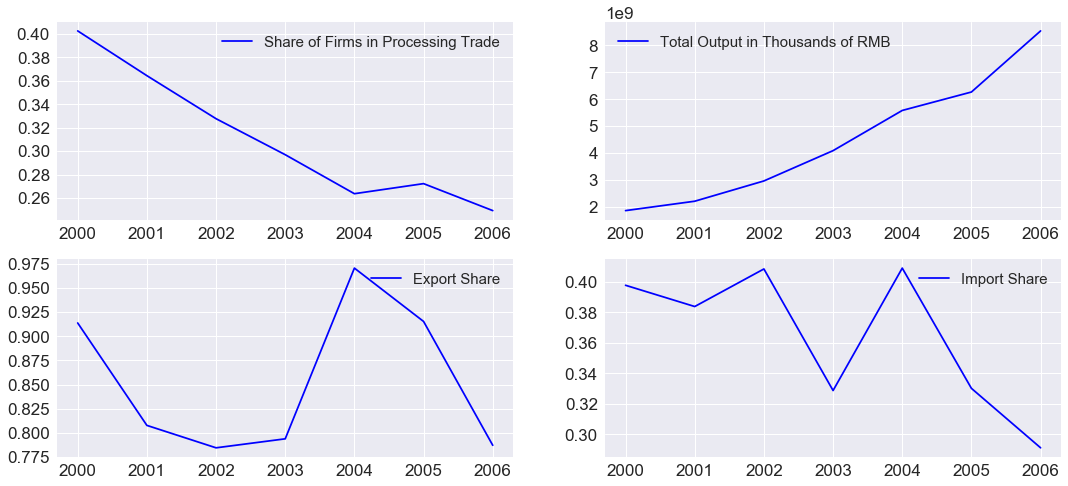

In [5]:
# visualzation for Total Number of Firms in Processing Trade Industry, Total Output, Export Share, Import Share
df1 = temp[temp.ex == 1]
df2 = temp[temp.im == 1]

total_output = temp.groupby(['year'])['totaloutput'].sum()
total_output1 = temp.groupby(['year'])['mainbusiness_revenue'].sum()
total_output2 = temp.groupby(['year'])['mainbusiness_cost'].sum()
total_export = df1.groupby(['year'])['value_ex'].sum() / total_output1
total_import = df2.groupby(['year'])['value_im'].sum() / total_output2

df = temp[temp.processing_trade==1]
total = temp.groupby(['year']).size()
ts = df.year.value_counts().sort_index() / temp.year.value_counts().sort_index() 

del total_output.index.name
del total_export.index.name
del total_import.index.name

fig = plt.figure(figsize=(18,8))

ax1 = plt.subplot(2, 2, 1)
ts.plot(color='blue', grid=True, label='Share of Firms in Processing Trade')
ax1.legend(loc="upper right", prop={'size': 15})
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(17) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(17) 

ax2 = plt.subplot(2, 2, 2)
total_output.plot(color='blue', grid=True, label='Total Output in Thousands of RMB')
ax2.legend(loc="upper left", prop={'size': 15})
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(17) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(17) 
t = ax2.yaxis.get_offset_text()
t.set_size(17)

ax3 = plt.subplot(2, 2, 3)
total_export.plot(color='blue', grid=True, label='Export Share')
ax3.legend(loc="upper right", prop={'size': 15})
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(17) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(17) 

ax4 = plt.subplot(2, 2, 4)
total_import.plot(color='blue', grid=True, label='Import Share')
ax4.legend(loc="upper right", prop={'size': 15})
for tick in ax4.xaxis.get_major_ticks():
    tick.label.set_fontsize(17) 
for tick in ax4.yaxis.get_major_ticks():
    tick.label.set_fontsize(17) 

plt.show()
fig.savefig('plot.png')

In [6]:
# set index: firm name and year
temp = temp.set_index(['frdwdm','year'])

# define new variables
temp['profit_rate'] = temp.mainbusiness_profit / temp.mainbusiness_revenue

temp['trade_depend_ex'] = (temp.value_ex * temp.ex) / temp.mainbusiness_revenue
temp['trade_depend_im'] = (temp.value_im * temp.im) / temp.mainbusiness_cost
temp['exchange_rate_depend'] = temp.exchange_rate * temp.trade_depend_ex + temp.exchange_rate * temp.trade_depend_im
temp['exchange_rate_CPI_adj'] = temp.CPIbase / (temp.CPI * temp.exchange_rate_depend)

temp['GDP_depend'] = temp.GDP #* temp.trade_depend_ex + temp.GDP * temp.trade_depend_im

temp['processing_trade_exr'] = temp.exchange_rate_CPI_adj * temp.processing_trade
temp['tfp'] = np.log(temp.totaloutput/temp.aemployment) - 1/3 * np.log(temp.total_asset/temp.aemployment)

temp['exchange_rate_medium'] = temp.D2 * temp.exchange_rate_CPI_adj
temp['exchange_rate_high'] = temp.D3 * temp.exchange_rate_CPI_adj

temp['added_value_per_worker'] = temp.valueadded / temp.aemployment
temp['capital_per_worker'] = temp.total_asset / temp.aemployment

In [9]:
# Fixed Effect Model
temp_y1 = np.log(temp['total_profit'])
temp_y4 = np.log(temp['mainbusiness_profit']) 
temp_y5 = np.log(temp['profit_rate'])
temp_y6 = np.log(temp['export_delivery_rate'])

temp_X1 = temp[['wage_payable','valueadded','debt_asset_ratio','aemployment',
                'Quantity','price','GDP_depend','exchange_rate_CPI_adj',
                'added_value_per_worker','capital_per_worker']].apply(np.log)
temp_X1 = temp_X1.merge(temp.processing_trade_exr.to_frame(), left_index=True, right_index=True)
temp_X1 = temp_X1.merge(temp.tfp.to_frame(), left_index=True, right_index=True)
temp_X1 = temp_X1.merge(temp.exchange_rate_medium.to_frame(), left_index=True, right_index=True)
temp_X1 = temp_X1.merge(temp.exchange_rate_high.to_frame(), left_index=True, right_index=True)

dta_temp1 = pd.concat([temp_y1, temp_X1], axis=1) # total_profit
dta_temp4 = pd.concat([temp_y4, temp_X1], axis=1) # mainbusiness_profit
dta_temp5 = pd.concat([temp_y5, temp_X1], axis=1) # profit_rate

In [19]:
# Fixed Effect Regression on Total Profit 
mod11 = PanelOLS.from_formula('total_profit ~ 1 + wage_payable + valueadded + \
                              Quantity + price + tfp + debt_asset_ratio + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', dta_temp1)
res11 = mod11.fit(cov_type='heteroskedastic')
print(res11) 

                          PanelOLS Estimation Summary                           
Dep. Variable:           total_profit   R-squared:                        0.1521
Estimator:                   PanelOLS   R-squared (Between):              0.5242
No. Observations:              157870   R-squared (Within):               0.1816
Date:                Mon, May 07 2018   R-squared (Overall):              0.5088
Time:                        15:21:50   Log-likelihood                -1.632e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1432.7
Entities:                       70024   P-value                           0.0000
Avg Obs:                       2.2545   Distribution:                F(11,87829)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             709.96
                            

In [ ]:
# Random Effect Regression on Total Profit 
random_mod11 = RandomEffects.from_formula('total_profit ~ 1 + wage_payable + valueadded + \
                              Quantity + price + tfp + debt_asset_ratio + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', dta_temp1)
random_res11 = random_mod11.fit(cov_type='heteroskedastic')
print(random_res11)

In [ ]:
# Hausman Test
hausman(res11, random_res11)

In [ ]:
# regression on mainbusiness_revenue is bad
# Fixed Effect Regression on Main Business Profit
mod12 = PanelOLS.from_formula('mainbusiness_profit ~ 1 + wage_payable + valueadded + \
                              Quantity + price + tfp + debt_asset_ratio + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', dta_temp4)
res12 = mod12.fit(cov_type='heteroskedastic')
print(res12) 

In [ ]:
# Random Effect Regression on Total Profit 
random_mod12 = RandomEffects.from_formula('mainbusiness_profit ~ 1 + wage_payable + valueadded + \
                              Quantity + price + tfp + debt_asset_ratio + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', dta_temp4)
random_res12 = random_mod12.fit(cov_type='heteroskedastic')
print(random_res12)

In [ ]:
# Hausman Test
hausman(res12, random_res12)

In [ ]:
# Fixed Effect Regression on Profit Rate
mod13 = PanelOLS.from_formula('profit_rate ~ 1 + wage_payable + valueadded + \
                              Quantity + price + tfp + debt_asset_ratio + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', dta_temp5)
res13 = mod13.fit(cov_type='heteroskedastic')
print(res13) # mainbusiness_profit; profit_rate; mainbusiness_revenue

In [ ]:
# Random Effect Regression on Profit Rate
random_mod13 = RandomEffects.from_formula('profit_rate ~ 1 + wage_payable + valueadded + \
                              Quantity + price + tfp + debt_asset_ratio + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', dta_temp5)
random_res13 = random_mod13.fit(cov_type='heteroskedastic')
print(random_res13)

In [ ]:
# Hausman Test
hausman(res13, random_res13)

In [ ]:
# Prepare Data for Fixed Effect Regression on Export Quantity/Price
temp_X21 = temp[temp.ex == 1]
temp_X21 = temp_X21[temp_X21.quantity_ex>0]

temp_X21 = temp_X21[['wage_payable','valueadded',
                'quantity_ex','value_ex','price','GDP_depend','exchange_rate_CPI_adj']].apply(np.log)
temp_X21 = temp_X21.merge(temp.processing_trade_exr.to_frame(), left_index=True, right_index=True)
temp_X21 = temp_X21.merge(temp.tfp.to_frame(), left_index=True, right_index=True)
temp_X21 = temp_X21.merge(temp.exchange_rate_medium.to_frame(), left_index=True, right_index=True)
temp_X21 = temp_X21.merge(temp.exchange_rate_high.to_frame(), left_index=True, right_index=True)

# Prepare Data for Fixed Effect Regression on Import Quantity/Price
temp_X22 = temp[temp.im == 1]
temp_X22 = temp_X22[temp_X22.quantity_im>0]

temp_X22 = temp_X22[['wage_payable','valueadded',
                'quantity_im','price','GDP_depend','exchange_rate_CPI_adj']].apply(np.log)
temp_X22 = temp_X22.merge(temp.processing_trade_exr.to_frame(), left_index=True, right_index=True)
temp_X22 = temp_X22.merge(temp.tfp.to_frame(), left_index=True, right_index=True)
temp_X22 = temp_X22.merge(temp.exchange_rate_medium.to_frame(), left_index=True, right_index=True)
temp_X22 = temp_X22.merge(temp.exchange_rate_high.to_frame(), left_index=True, right_index=True)

In [ ]:
# Fixed Effect Regression on Export Quantity
mod21 = PanelOLS.from_formula('quantity_ex ~ 1 + wage_payable + \
                              valueadded + price + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X21)
res21 = mod21.fit(cov_type='heteroskedastic')
print(res21)

In [ ]:
# Random Effect Regression on Export Quantity
random_mod21 = RandomEffects.from_formula('quantity_ex ~ 1 + wage_payable + \
                              valueadded + price + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X21)
random_res21 = random_mod21.fit(cov_type='heteroskedastic')
print(random_res21)

In [ ]:
# Hausman Test
hausman(res21, random_res21)

In [ ]:
# Fixed Effect Regression on Import Quantity
mod22 = PanelOLS.from_formula('quantity_im ~ 1 + wage_payable + \
                              valueadded + price + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X22)
res22 = mod22.fit(cov_type='heteroskedastic')
print(res22)

In [ ]:
# Random Effect Regression on Import Quantity
random_mod22 = RandomEffects.from_formula('quantity_im ~ 1 + wage_payable + \
                              valueadded + price + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X22)
random_res22 = random_mod22.fit(cov_type='heteroskedastic')
print(random_res22)

In [ ]:
# Hausman Test
hausman(res22, random_res22)

In [ ]:
# Fixed Effect Regression on Export Price
mod31 = PanelOLS.from_formula('price ~ 1 + wage_payable + \
                              valueadded + quantity_ex + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X21)
res31 = mod31.fit(cov_type='heteroskedastic')
print(res31)

In [ ]:
# Random Effect Regression on Export Price
random_mod31 = RandomEffects.from_formula('price ~ 1 + wage_payable + \
                              valueadded + quantity_ex + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium + exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X21)
random_res31 = random_mod31.fit(cov_type='heteroskedastic')
print(random_res31)

In [ ]:
# Hausman Test
hausman(res31, random_res31)

In [ ]:
# Fixed Effect Regression on Import Price
mod32 = PanelOLS.from_formula('price ~ 1 + wage_payable + \
                              valueadded + quantity_im + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium+exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X22)
res32 = mod32.fit(cov_type='heteroskedastic')
print(res32)

In [ ]:
# Random Effect Regression on Import Price
random_mod32 = RandomEffects.from_formula('price ~ 1 + wage_payable + \
                              valueadded + quantity_im + tfp + GDP_depend + \
                              exchange_rate_CPI_adj + processing_trade_exr + \
                              exchange_rate_medium+exchange_rate_high + \
                              EntityEffects + TimeEffects', temp_X22)
random_res32 = random_mod32.fit(cov_type='heteroskedastic')
print(random_res32)

In [ ]:
# Hausman Testd
hausman(res32, random_res32)

In [ ]:
# logit model on export
exog = add_constant(temp_X1)

logit1 = sm.Logit(temp['ex'], exog)

result1 = logit1.fit()
print(result1.summary2())

In [ ]:
# logit model on import
logit2 = sm.Logit(temp['im'], exog)

result2 = logit2.fit()
print(result2.summary2())

In [ ]:
temp.ownership_name.value_counts()

In [ ]:
temp.transport_name.value_counts()

##### Variables Description

frdwdm(公司名); year(年份); youbian(邮编); setup_year(开业年); setup_month(开业月); 

totaloutput(工业总产值); newproduct_output(工业总产值-新产品产值); total_sale(工业销售产值); export(工业销售产值-出口交货值); aemployment(全部职工); valueadded(工业增加值); longrun_invest(长期投资); totalfixed_asset(固定资产合计); fixed_asset_op(固定资产-生产经营用); depreciate(累计折旧); depreciate_tyear(累计折旧-本年折旧); fixedasset_net(固定资产净值年平均余额); total_asset(资产总计); owner_rights(所有者权益合计); paicl_up_capital(实收资本); so_capital(国家资本金); co_capital(集体资本金); lp_capital(法人资本金); p_capital(个人资本金); gat_capital(港澳台资本金); foreign_capital(外商资本金); 

mainbusiness_revenue(主营业务收入); mainbusiness_cost(主营业务成本); finance_expense(财务费用); fe_interest(财务费用-利息支出); total_profit(利润总额); advertise_expense(广告费); wage_payable(本年应付工资总额); wp_mainbusiness(本年应付福利费总额); totalintermediate_input(工业中间投入合计); 


drop variables: id(公司代码); frdm(法人代码); fddbr(法人); quhao(区号); dianhua(固定电话); fenjihao(分机号); chuanzhen(传真); email; web; registertype(登记注册类型); lishu(隶属关系); totalasset(资产总计含缺省值); e_state(!=so_capital); e_collective(=co_capital); e_individual(=p_capital); e_legal_person(=lp_capital); e_hmt(=gat_capital); e_foreign(=foreign_capital); e_total(=paicl_up_capital); soe_sh, collect_sh, lp_sh, p_sh, hmt_sh, foreign_sh(shares); state, collective, private, hmt, foreign(dummies); frdmid; firmid; newid(=frdmid-1);

unclear: edu(职工教育费), rd_expense(研究开发费), code_cnty, cic_adj, BR_deflator, I, cic2(first two digits of cic_adj), lny, lnl, lnk, lnm, lnk_net, investment_net(投资收益), lninvest_net(=ln(investment_net)), lninvest, 'ownership', 'ownerships', 

In [ ]:
# single plot: plot the number of firms in processing trade industry

fig = plt.figure(figsize=(12,5))

ax1 = ts.plot(color='blue', grid=True, label='Number')

h1, l1 = ax1.get_legend_handles_labels()

plt.legend(h1, l1, loc=3, prop={'size': 17})
plt.show()
fig.savefig('plot1.png')

In [ ]:
# Fixed Effect logit model on export
temp_X4 = pd.concat([temp_y8, temp_X1], axis=1)
FE1 = FixedEffectPanelModel()
FE1.fit(temp_X4, 'ex', verbose=True)
FE1.summary()
# FE.beta
# FE.beta_se

# Fixed Effect logit model on import
temp_X5 = pd.concat([temp_y9, temp_X1], axis=1)
FE2 = FixedEffectPanelModel()
FE2.fit(temp_X5, 'im', verbose=True)
FE2.summary()